#  1. Pull Data



Grabbing WebIDs ...
WebID collection complete!
14:48:37: Sending API request... Chunk 1 of 1
14:48:38: Response recieved for 1 tags! (0.94)
Grabbing WebIDs ...
WebID collection complete!
14:48:38: Sending API request... Chunk 1 of 1
14:48:39: Response recieved for 1 tags! (1.11)


Text(0, 0.5, 'Electricity')

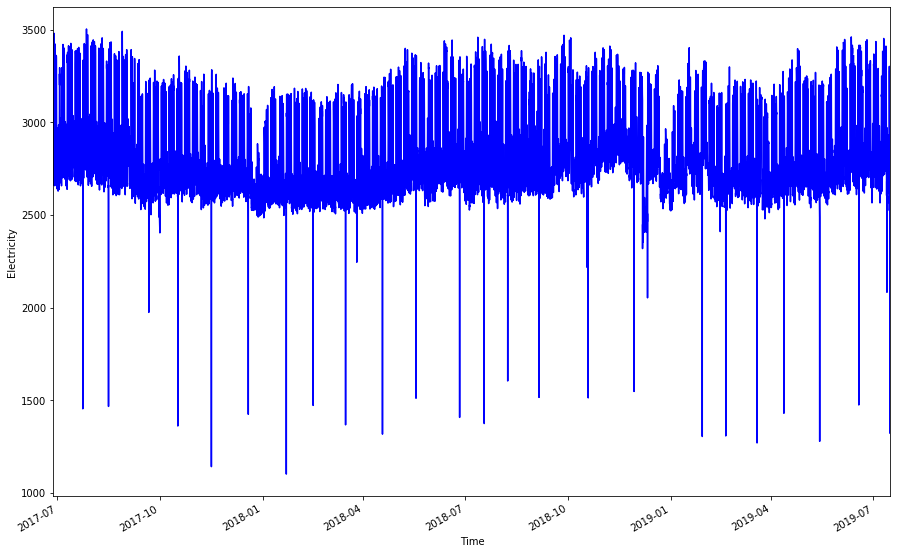

In [6]:

import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df2 = pc.get_stream_by_point(second_points, start = start, end = end, calculation=calculation, interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")

# 2. Standard Deviation Method


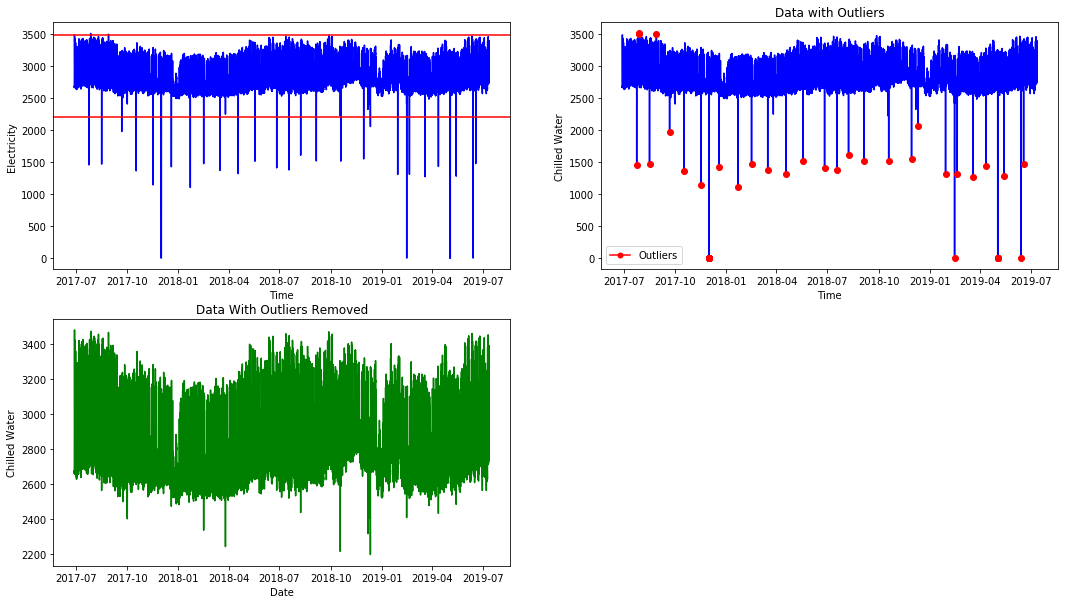

In [7]:
def another_outlier_detection(series):
    #this is a function that calculates whether an outlier exists based on how far it deviates from the mean values
    #if it deviates more than 2o away, it is flagged
    #we return a plot of the data and outliers    
    series.replace(np.nan, 0, inplace=True)
    values = list(series.values)
    mean = series.values.mean()
    sd_value = np.std(values)
    sd  = 2.5*sd_value    
    upper_hand = mean + sd
    lower_hand = mean - sd
    #plot data with standard deviation, upper threshold marked
    plt.figure(figsize  =(18, 10))
    plt.subplot(2, 2, 1)
    plt.plot(series.index, series.values, color = "blue")
    plt.axhline(y = upper_hand, color = 'red')
    plt.axhline(y = lower_hand, color = 'red')
    plt.xlabel("Time")
    plt.ylabel("Electricity")
    outliers = []
    plt.subplot(2, 2, 2)
    plt.plot(series.index, series.values, color = 'blue')
    index_outliers = []
    for i in range(0, len(values)):
        value = series.values[i]
        if value > upper_hand or value < lower_hand:
            index_outliers.append(i)
            date_index = series.index[i]
            plt.plot(date_index, value, color = 'red', marker = 'o')         
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers',
                         markersize=5)]
    plt.legend(handles=legend_elements, loc='best')
    plt.xlabel("Time")
    plt.ylabel("Chilled Water")
    plt.title("Data with Outliers")
    #plot data with outliers removed
    plt.subplot(2, 2, 3)
    #get indexes of non-outlier data
    non_outlier_indexes = [i for i in list(range(len(series))) if i not in index_outliers]
    non_outlier_values = [series.values.tolist()[v] for v in non_outlier_indexes]
    non_outlier_dates = [series.index[v] for v in non_outlier_indexes]
    plt.plot(non_outlier_dates, non_outlier_values, color = 'green')
    plt.title("Data With Outliers Removed")
    plt.xlabel("Date")
    plt.ylabel("Chilled Water")
 


#call the function
another_outlier_detection(series)






# 3. K-Means Clustering

[5269 6145 3773 2441]


Text(0, 0.5, 'Data Clusters')

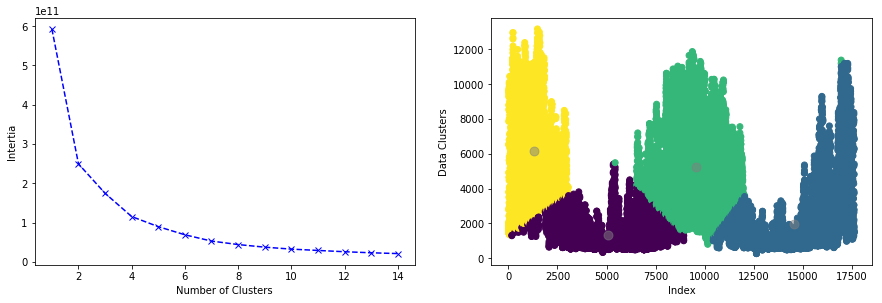

In [28]:


x = range(len(series))
y = series.values
from sklearn.cluster import KMeans
#combine the index with the values
data = np.column_stack([x, y])
#code for optimum number of clusters
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
def get_best_cluster_size():
    sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, sum_of_squared_distances, "--bx")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Intertia")

get_best_cluster_size()


#in the case of chilled water, the optimum number is 4
knn = KMeans(n_clusters = 4)
knn.fit(data)
labels = knn.labels_
print(np.bincount(labels))
plt.subplot(2, 2, 2)
plt.scatter(x, y, c = labels)
plt.scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], c = 'gray', marker = "o", s = 80, alpha = 0.5)
plt.xlabel("Index")
plt.ylabel("Data Clusters")

# 4. Moving Average Method


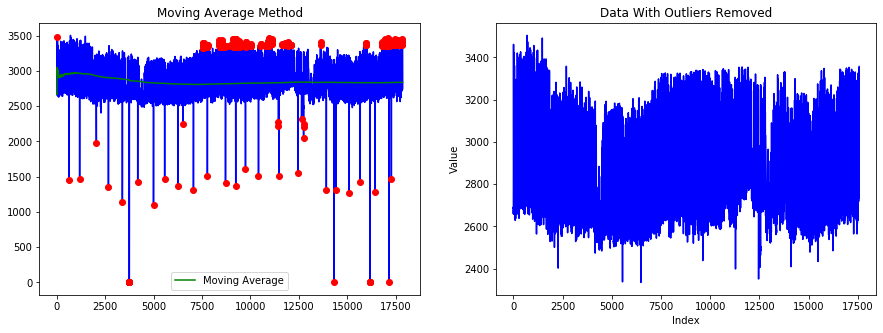

In [9]:


def moving_average_outlier_detection(series):
    #this is a function that looks at how far away each point is from the moving aka rolling average
    #if it differs significantly, it is flagged
    outliers = []
    moving_average = []
    comparisons = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
    ax1.plot(series.values, color = "blue")
    for i in range(len(series)):
        #get each value in the series
        current_value = series[i]
        end = i + 1
        #current series i.e. [0:1], [0:2], [0:3]
        current_series = series[0:end]
        #the moving average including each point
        current_ma = sum(current_series)/(len(current_series))
        moving_average.append(current_ma)
        #compare the current point in the time series to the moving average
        comparison = abs((current_value - current_ma)/(current_ma))
        comparisons.append(comparison)
    #determine threshold
    threshold = np.mean(comparisons) + 2*np.std(comparisons)
    index_outliers = []
    for i in range(len(comparisons)):
        comparison = comparisons[i]
        if comparison > threshold:
            index_outliers.append(i)
            ax1.plot(i, series.values.tolist()[i], color = "red", marker = "o")
    ax1.plot(moving_average, color = "green", label = 'Moving Average')
    ax1.set_title("Moving Average Method")
    ax1.legend(loc = "best")    
    #plot data with outliers removed
    non_outlier_indexes = [i for i in list(range(len(series))) if i not in index_outliers]
    non_outlier_data = [series.values[i] for i in non_outlier_indexes]
    ax2.plot(non_outlier_data, color = "blue")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")
    ax2.set_title("Data With Outliers Removed")
    



    


moving_average_outlier_detection(series)    




                
        

# 7. Hierarchical (Agglomerative) Clustering


array([2278, 5795,  570,  931, 2168,  732, 1386, 1086,  641, 2095],
      dtype=int64)

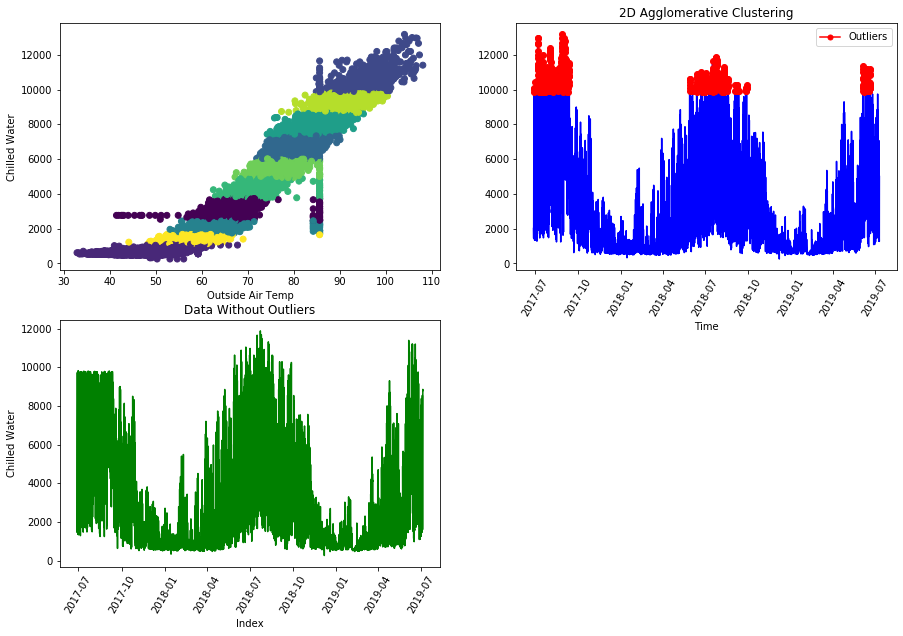

In [96]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.lines import Line2D

#use outside air temperature as x, since it correlates very well with chilled water + heating
new_df = pd.merge_asof(df, df2, on = "Timestamp")
new_df = new_df.dropna()
#x = temperature
x = new_df.iloc[:, 2]
#y = chilled water
y = new_df.iloc[:, 1]
#combined, new 2d data
data = new_df.iloc[:, [2, 1]]


def get_aggo_clustering():
    agg_cluster = AgglomerativeClustering(n_clusters = 10)
    #fit to data
    agg_cluster.fit(data)
    labels = agg_cluster.labels_
    agg_df = pd.DataFrame(dict(x = x, y = y, labels = labels))
    fig = plt.figure(figsize = (15, 10))
    plt.subplot(2, 2, 1)
    plt.scatter(x, y, c=labels, cmap='viridis') 
    plt.xlabel("Outside Air Temp")
    plt.ylabel("Chilled Water")
    #filter by the cluster with the highest average mean, containing outlier spikes
    counts = agg_df.groupby(['labels'])['y'].mean()
    counts = counts.sort_values(ascending=False)
    outlier_cluster  = counts.index[0]
   #filter data by outlier cluster
    agg_df = agg_df.loc[(agg_df.labels == outlier_cluster)]
    #get all chilled water/heat/elec for that cluster
    outliers = agg_df['y'].tolist()
    plt.subplot(2, 2, 2)
    plt.plot(series.index, series.values, color = "blue")
    for outlier in outliers:
        index = series.values.tolist().index(outlier)
        date_index = series.index[index]
        plt.plot(date_index, outlier, color = "red", marker = "o")
    legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers', markersize=5)]
    plt.legend(handles=legend_elements, loc='best')
    plt.title("2D Agglomerative Clustering")
    plt.xlabel("Time")
    plt.xticks(rotation=60)
    plt.subplot(2, 2, 3)
    new_indexes = [i for i in list(range(len(new_df.iloc[:, 1]))) if new_df.iloc[:, 1].tolist()[i] not in outliers]
    new_data = [series.values.tolist()[i] for i in new_indexes]
    new_data_dates = [series.index[i] for i in new_indexes]
    plt.plot(new_data_dates, new_data, color = "green")
    plt.xlabel("Index")
    plt.ylabel("Chilled Water")
    plt.title("Data Without Outliers")
    plt.xticks(rotation=60)
    label_counts = np.bincount(labels)
    return label_counts

 

#get data, x, y
#x is air temp and y is chilled water/heat/electricity
get_aggo_clustering()

#call the function




# DBSCAN clustering

Initial Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]
Estimated number of clusters: 11


Text(0.5, 1.0, 'Data Without Outliers')

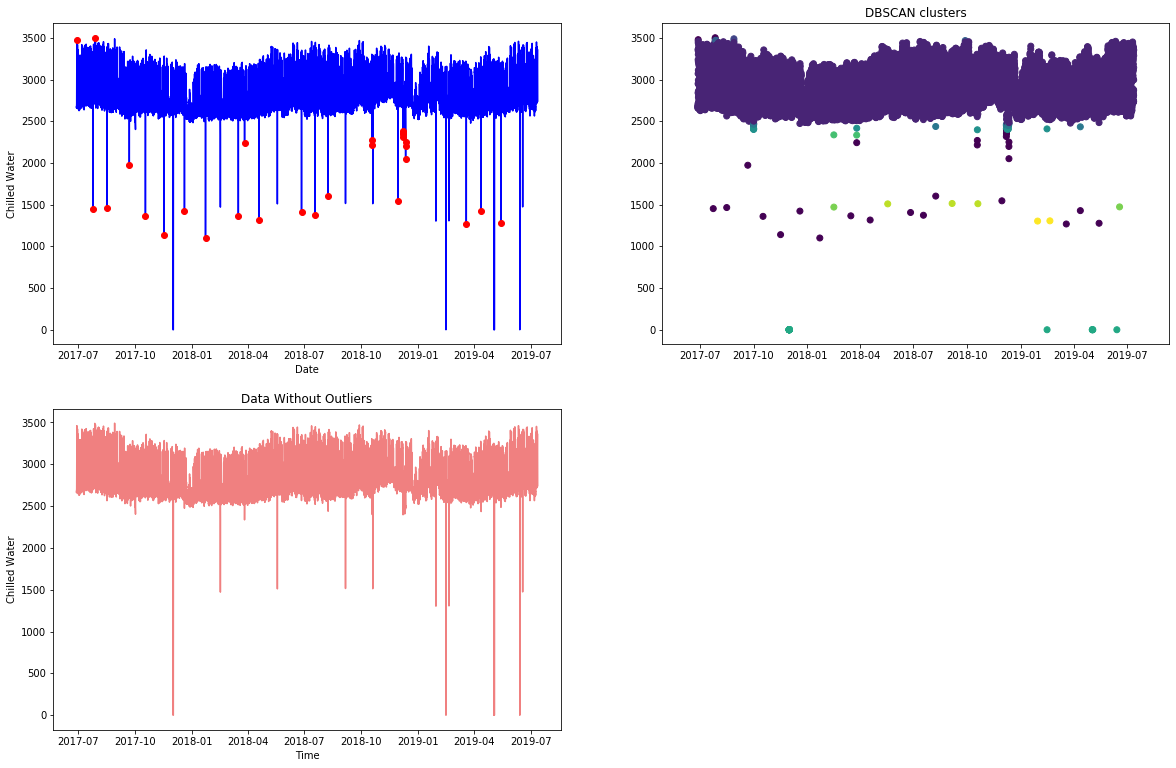

In [10]:
from sklearn.cluster import DBSCAN

#retrieve chilled water data again
#lower eps = lower threshold for outliers, higher eps = higher threshold for outliers
x = np.array(series.values).reshape(-1, 1)
clustering = DBSCAN(eps=4, min_samples=2).fit(x)
indexes = []
for i in range(len(clustering.labels_)):
    label = clustering.labels_[i]
    #label is -1 = noise = outlier
    if label == -1:
        indexes.append(i)
outliers = []
#plot outliers
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color = 'blue')
for index in indexes:
    outlier = series.values.tolist()[index]
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = 'red', marker = 'o')
plt.xlabel("Date")
plt.ylabel("Chilled Water")

    

n_clusters_ = len(set(clustering.labels_))
print("Initial Labels:", clustering.labels_.tolist()[0:20])
print('Estimated number of clusters: %d' % n_clusters_)
#plot dbscan clusters
plt.subplot(2, 2, 2)
plt.scatter(series.index, series.values, c = clustering.labels_)
plt.title("DBSCAN clusters")
    
#plot data without outliers
plt.subplot(2, 2, 3)
non_outlier_indexes = [i for i in list(range(len(series))) if i not in indexes]
non_outlier_data = [series.values.tolist()[j] for j in non_outlier_indexes]
non_outlier_dates = [series.index[k] for k in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data, color = 'lightcoral')
plt.xlabel("Time")
plt.ylabel("Chilled Water")
plt.title("Data Without Outliers")    
    
    
    
    
#eps=2 the distance between them needs to be <=2 to be considered part of a cluster and not noise
#this is a low threshold for outliers since many points will not be this close together and thus will be counted as noise
#eps=5 the distance between them needs to be <=5 to be considered part of a cluster and not noise
#this is a higher threshold for outliers since fewer points will be outside this distance than 2




# Quantile Method

,ninety_fifth,fifth
0,3279.030965,2566.783311


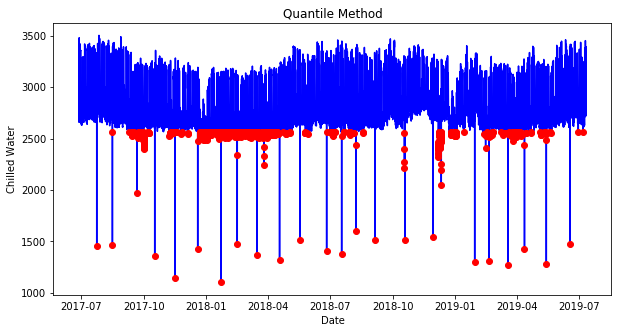

In [14]:
#this method works for 1d data, which is what we have
#simply trim the top X percent off the top and bottom of the time series and flag these as outliers
#get the trimmed series values
from scipy.stats import tmean, scoreatpercentile
X = df.iloc[:, 0]
upper_bound = X.quantile(0.95)
lower_bound = X.quantile(0.05)
outliers = []
plt.figure(figsize = (10, 5))
plt.plot(series.index, series.values, color = "blue")
for i in range(len(series.values)):
    value = series.values[i]
    if value < lower_bound:
        date = series.index[i]
        plt.plot(date, value, color = "red", marker = "o")
plt.title("Quantile Method")
plt.xlabel("Date")
plt.ylabel("Chilled Water")
info_df = pd.DataFrame(dict(ninety_fifth = upper_bound, fifth = lower_bound), index = [0])
info_df
        
        
        

# Isolation Forest

Threshold: -0.058112664945624504
[ 0.06211358  0.06675029  0.06675029  0.07580273  0.06166873  0.07073192
  0.0655621   0.02866321  0.01516505  0.00552469 -0.01956706 -0.069858
 -0.08529424 -0.1830929  -0.17619539 -0.17163578 -0.08489837 -0.05453672
 -0.00721451  0.01528549]


Text(0.5, 1.0, 'Data Without Outliers')

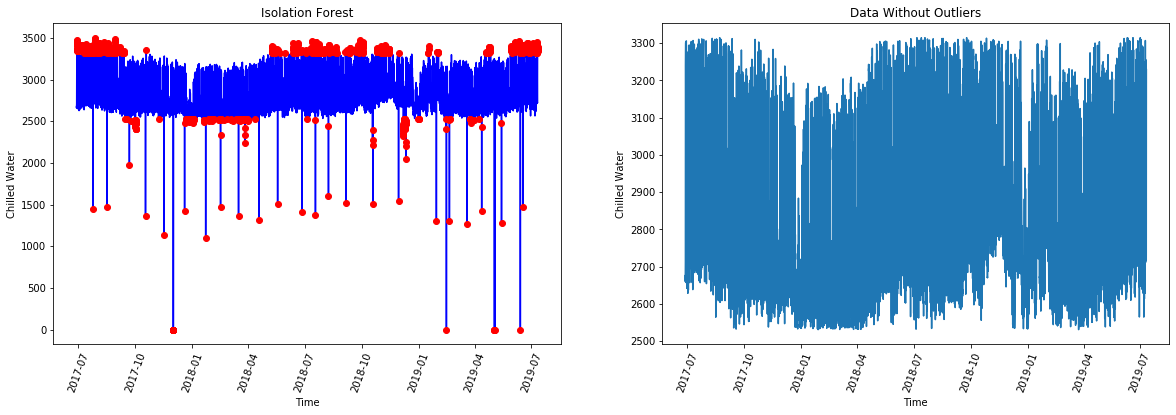

In [28]:
from sklearn.ensemble import IsolationForest
from scipy import stats

#retrieve chilled water data and reshape



#series.replace(np.nan, 0, inplace=True)
#series.replace(np.inf, 0, inplace=True)

X = np.array(series.values).reshape(-1, 1)
model = IsolationForest().fit(X)
scores_pred = model.decision_function(X)
threshold = stats.scoreatpercentile(scores_pred, 100 * 0.05)
#print the threshold
print("Threshold:", threshold)
all_indexes = list(range(len(series)))
indexes = [i for i in all_indexes if scores_pred[i] < threshold]
plt.figure(figsize = (20, 13))
print(scores_pred[0:20])
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color= "blue")
#plot outliers
for index in indexes:
    outlier_point = series.values.tolist()[index]
    date_index = series.index[index]
    plt.plot(date_index, outlier_point, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Chilled Water")
plt.title("Isolation Forest")
plt.xticks(rotation = 70)
plt.subplot(2, 2, 2)
#extract data without outliers
non_outlier_indexes = [i for i in all_indexes if i not in indexes]
non_outlier_dates = [series.index[j] for j in non_outlier_indexes]
non_outlier_data = [series.values.tolist()[i] for i in non_outlier_indexes]
non_outlier_series = pd.Series(non_outlier_data, index = non_outlier_dates)
plt.plot(non_outlier_series.index, non_outlier_series.values)
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Chilled Water")
plt.title("Data Without Outliers")



# Agglomerative Clustering (One Variable)

Text(0.5, 0, 'Date')

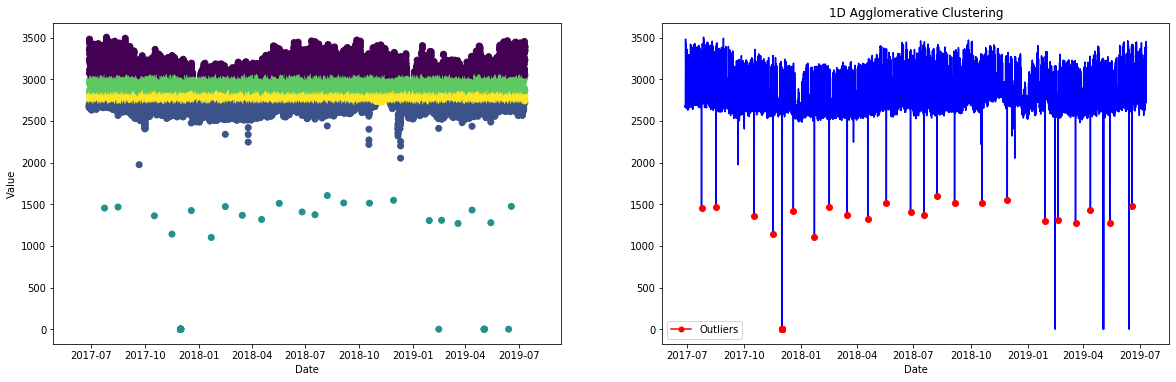

In [30]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib.lines import Line2D


#retrieve chilled water data
X = np.array(series.values).reshape(-1, 1)
#fit clustering algo
agg_cluster = AgglomerativeClustering(n_clusters = 5)
#fit to data
agg_cluster.fit(X)
labels = agg_cluster.labels_
#plot for clusters, plot for outliers
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
x = series.index
y = series.values
plt.scatter(x, y, c=labels, cmap='viridis') 
plt.xlabel("Date")
plt.ylabel("Value")
#own df
agg_df = pd.DataFrame(dict(x = range(len(series)), y = series.values, labels = labels))
#retrieve outlier cluster, which is the cluster with the highest mean
counts = agg_df.groupby(['labels'])['y'].mean()
counts = counts.sort_values(ascending=True)
outlier_cluster = counts.index[0]
agg_df = agg_df.loc[agg_df['labels'] == outlier_cluster]
#retrieve outliers
outliers = agg_df['y'].tolist()
plt.subplot(2, 2, 2)
plt.plot(x, y, color = "blue")
for outlier in outliers:
    index = series.values.tolist().index(outlier)
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = "red", marker = "o")
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers', markersize=5)]
plt.legend(handles=legend_elements, loc='best')
plt.title("1D Agglomerative Clustering")
plt.xlabel("Date")  




# Linear Regression Method

Text(0.5, 1.0, 'Data Without Outliers')

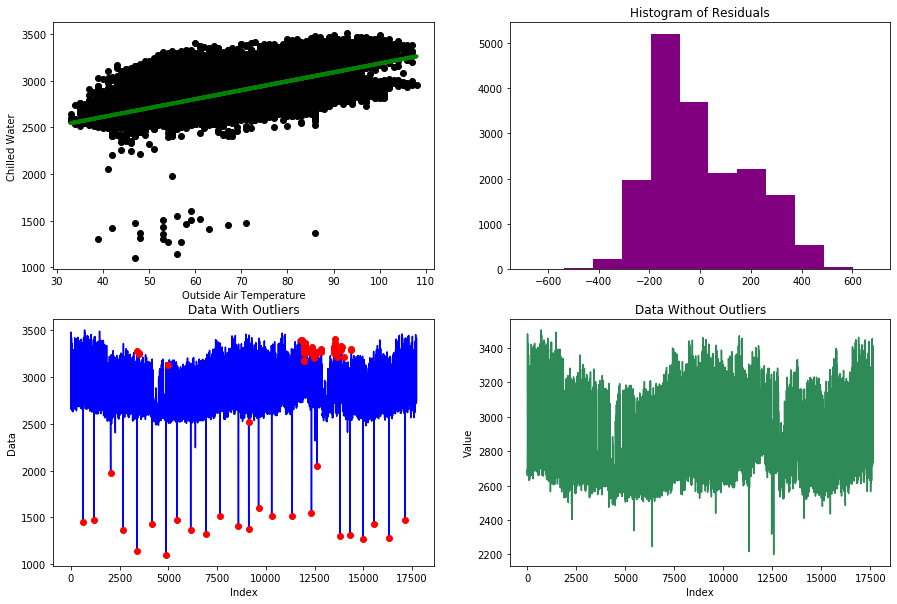

In [30]:
from sklearn.linear_model import LinearRegression

#pull data - df is chilled water, df2 is outside air temperatue
new_df = pd.merge_asof(df, df2, on = "Timestamp")
#drop any NA values
new_df = new_df.dropna()


#round columns
for col in new_df.columns[1:3]:
    new_df[col] = new_df[col].apply(lambda x: round(x, 0))
#reshape the data so you can use it in the linear reg. model
#here is where you would apply x^2
x =  np.array(new_df.iloc[:, 2]).reshape(-1, 1)
y = np.array(new_df.iloc[:, 1]).reshape(-1, 1)
lnn = LinearRegression().fit(x, y)
#the linear model's fitted predictions
preds = lnn.intercept_ + lnn.coef_ * x
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
#the residuals: actual chilled water - predicted
residuals = (y - preds).reshape(-1, 1)
upper_bound = np.mean(residuals) + 2.5*np.std(residuals)
lower_bound = np.mean(residuals) - 2.5*np.std(residuals)
indexes = []
for i in range(len(residuals)):
    residual = residuals[i]
    if residual > upper_bound or residual < lower_bound:
        indexes.append(i)
y = np.ravel(y).tolist()
outliers = [y[i] for i in indexes]
plt.scatter(x, y, color = "black")
plt.plot(x, preds, color = "green", linewidth=4)
plt.xlabel("Outside Air Temperature")
plt.ylabel("Chilled Water")
plt.subplot(2, 2, 2)
#plot residuals
plt.hist(residuals, color = "purple", bins = 20)
plt.xlim([-750, 750])
plt.title("Histogram of Residuals")
plt.subplot(2, 2, 3)
plt.plot(y, color = "blue")
for i in indexes:
    outlier = y[i]
    plt.plot(i, outlier, color = "red", marker = "o")
plt.xlabel("Index")
plt.ylabel("Data")
plt.title("Data With Outliers")
#retrieve data without outliers
non_outlier_indexes = [i for i in range(len(y)) if i not in indexes]
new_data = [y[i] for i in non_outlier_indexes]
plt.subplot(2, 2, 4)
plt.plot(new_data, color = "seagreen")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Data Without Outliers")






# Time Series Decomposition + Standard Deviation



Text(0.5, 1.0, 'Data Without Outliers')

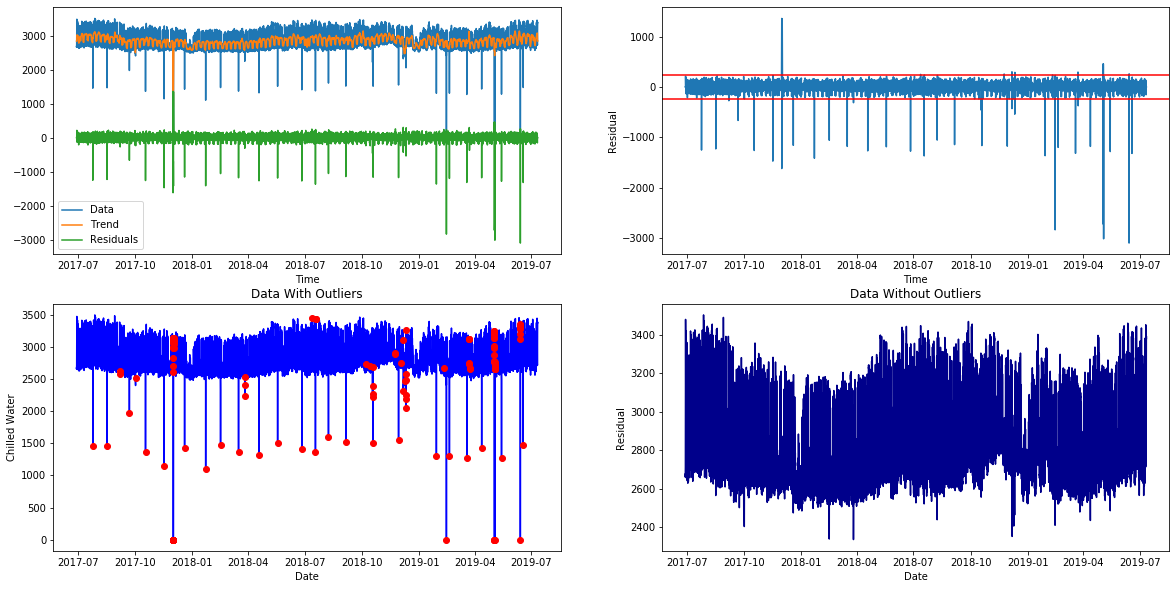

In [31]:
#first, extract trend + seasonality + noise
from statsmodels.tsa.seasonal import seasonal_decompose
#chilled water series
chilled_df = pd.DataFrame(series)
chilled_df = chilled_df.asfreq("H", method="bfill")
result = seasonal_decompose(chilled_df)
trend = result.trend
trend = result.trend.fillna(result.trend.mean())
seasonality = result.seasonal
resid = result.resid
resid = resid.fillna(resid.mean())
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.plot(chilled_df.index, chilled_df.values, label = "Data")
plt.plot(trend.index, trend.values, label = "Trend")
plt.plot(resid.index, resid.values, label = "Residuals")
plt.xlabel("Time")
plt.legend(loc = "best")
#standard deviation method
upper_bound = resid.mean() + 2*np.std(resid)
lower_bound = resid.mean() - 2*np.std(resid)
#plot residuals with upper bound, lower bound marked as line
plt.subplot(2, 2, 2)
plt.plot(resid.index, resid.values)
plt.axhline(y = int(upper_bound), color = "red")
plt.axhline(y = int(lower_bound), color = "red")
plt.xlabel("Time")
plt.ylabel("Residual")

#get outliers
resids = np.ravel(resid.values).tolist()
indexes = [resids.index(r) for r in resids if r > int(upper_bound) or r < int(lower_bound)]
plt.subplot(2, 2, 3)
plt.plot(chilled_df.index, chilled_df.values, color = "blue")
for index in indexes:
    chilled_outlier = np.ravel(chilled_df.values).tolist()[index]
    date_index = chilled_df.index[index]
    plt.plot(date_index, chilled_outlier, color = "red", marker = "o")
plt.xlabel("Date")
plt.ylabel("Chilled Water")
plt.title("Data With Outliers")
    
plt.subplot(2, 2, 4)
all_data = np.ravel(chilled_df.values).tolist()
non_outliers_index = [i for i in range(chilled_df.shape[0]) if i not in indexes]
non_outliers = [all_data[j] for j in non_outliers_index]
non_outliers_date = [chilled_df.index[k] for k in non_outliers_index]
plt.plot(non_outliers_date, non_outliers, color = "darkblue")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Data Without Outliers")




 

# Time Series Decomposition + KMeansClustering

In [ ]:
#retrieve residuals again

Cluster Totals 
 3    3034
1    3019
4    2990
2    2959
0    2930
5    2914
Name: label, dtype: int64
2.010186713556451


Text(0, 0.5, 'Chilled Water')

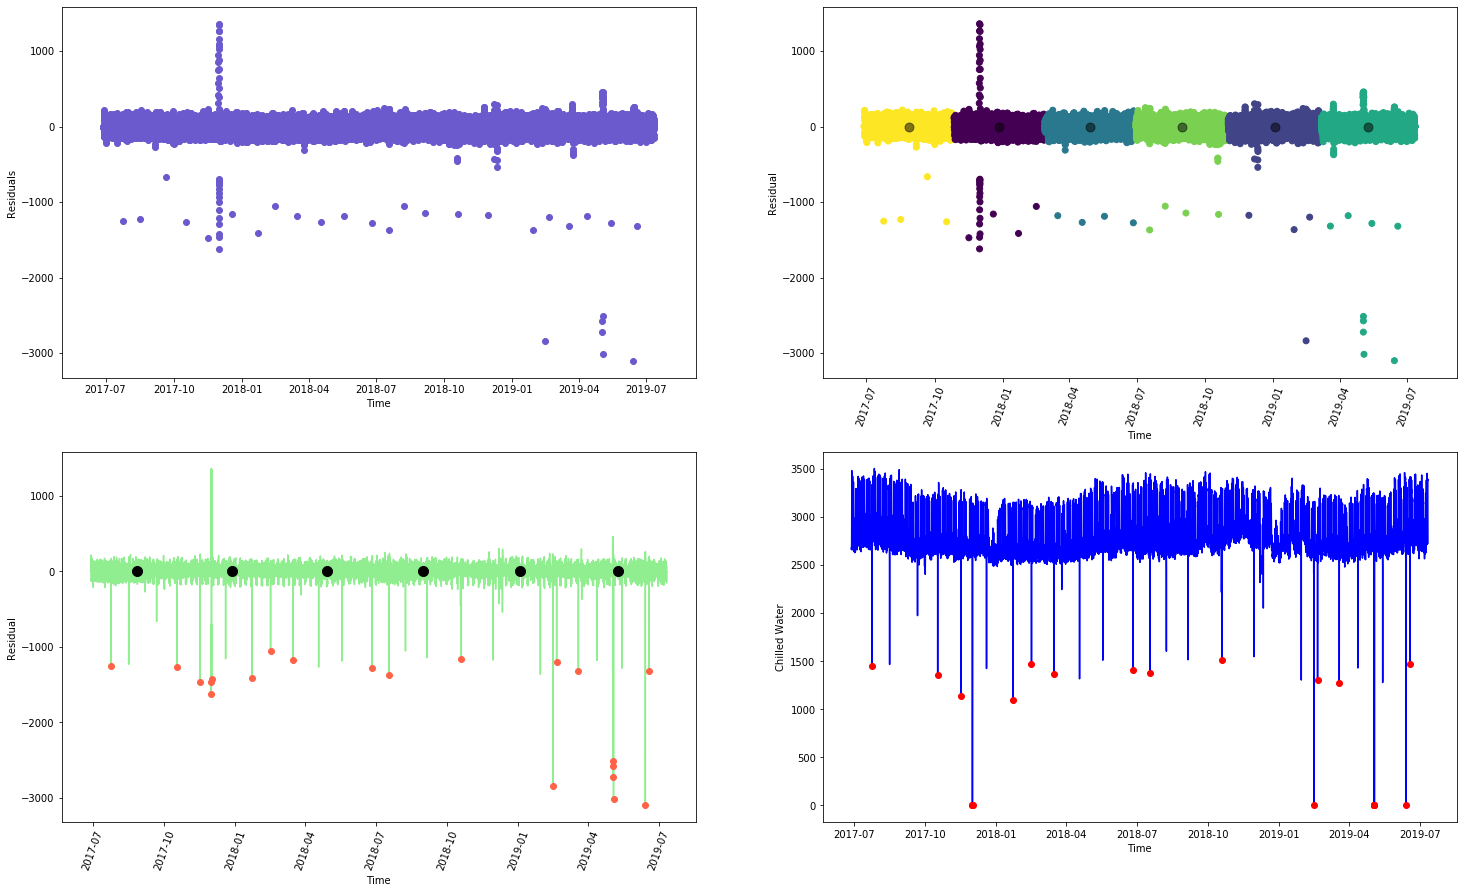

In [50]:
from scipy.spatial import distance


y = resid
y_shaped = np.array(y)
#using KMeans
from sklearn.cluster import KMeans
x= range(y.shape[0])
data = np.column_stack([x, y_shaped])
knn = KMeans(n_clusters = 6)
knn.fit(data)
knn.cluster_centers_
plt.figure(figsize = (25, 15))
#plot original residuals
plt.subplot(2, 2, 1)
plt.scatter(resid.index, resid.values, color = 'slateblue')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.subplot(2, 2, 2)
#plt.scatter(x, y_shaped)
indexes = [int(round(x, 0)) for x in knn.cluster_centers_[:, 0]]
date_indexes = [resid.index[i] for i in indexes]
plt.scatter(resid.index, resid.values, c = knn.labels_)
plt.scatter(date_indexes, knn.cluster_centers_[:, 1], s = 80, alpha = 0.5, marker = "o", color = "black")
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Residual")


#put x, y and label into df
y = resid.iloc[:, 0].tolist()
kmeans_df = pd.DataFrame(dict(x = x, y = y, label = knn.labels_))
print("Cluster Totals \n", kmeans_df['label'].value_counts())
#extract cluster center for each individual point
cluster_centers = knn.cluster_centers_.tolist()
all_labels = [int(k) for k in kmeans_df['label'].tolist()]
each_cluster_center_x = [cluster_centers[j][0] for j in all_labels]
each_cluster_center_y = [cluster_centers[l][1] for l in all_labels]
kmeans_df['center_x'] = each_cluster_center_x
kmeans_df['center_y'] = each_cluster_center_y
#extract the distance from each individual point to the cluster center
m = range(kmeans_df.shape[0])
distances = [distance.euclidean((kmeans_df.iloc[i, 0], kmeans_df.iloc[i, 1]), (kmeans_df.iloc[i, 3],
                                                        kmeans_df.iloc[i, 4])) for i in m]
#add to the dataframe
kmeans_df['distances'] = distances
#compare the distance of each point to its cluster center, to the mean cluster distances
#first, extract the mean cluster distances
mean_cluster_distances = kmeans_df.groupby('label')['distances'].mean().tolist()
#from there, get the evaluation value - each point's distance to the cluster center, divided by the average distance of all 
#points to the center for that cluster
all_mean_cluster_distances = [mean_cluster_distances[i] for i in kmeans_df['label'].tolist()]
kmeans_df['mean_cluster_distances'] = all_mean_cluster_distances
kmeans_df['evaluation_value'] = kmeans_df['distances']/kmeans_df['mean_cluster_distances']
#determine the threshold for an outlier
threshold_evaluation_value = kmeans_df['evaluation_value'].mean() + 1.8*np.std(kmeans_df['evaluation_value'])
print(threshold_evaluation_value)
evaluation_outliers_indexes = [kmeans_df['evaluation_value'].tolist().index(o) for o in kmeans_df['evaluation_value'].tolist()
                       if o > threshold_evaluation_value]
#plot residuals
plt.subplot(2, 2, 3)
plt.plot(resid.index, resid.values, color = 'lightgreen', zorder=1)
plt.scatter(date_indexes, knn.cluster_centers_[:, 1], s = 100, marker = "o", color = "black", zorder=2)
for index in evaluation_outliers_indexes:
    residual_outlier = kmeans_df['y'][index]
    date_index = resid.index.tolist()[index]
    plt.plot(date_index, residual_outlier, marker = 'o', color = 'tomato')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.xticks(rotation = 70)

#then plot data with outliers
plt.subplot(2, 2, 4)
#retrieve chilled water outliers based on outlier indexes
plt.plot(chilled_df.index, chilled_df.values, color = 'blue')
for index in evaluation_outliers_indexes:
    chilled_outlier = chilled_df.values.tolist()[index]
    date_index = chilled_df.index[index]
    plt.plot(date_index, chilled_outlier, marker = 'o', color = 'red')
plt.xlabel("Time")
plt.ylabel("Chilled Water")




# Time Series Decomposition + Agglomerative Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering
#extract residuals and plot again
resid.head(5)
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
plt.plot(resid.index, resid.values, color = 'blueviolet')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals")
#second plot: fit aggclustering to residuals, then scatter: plt.scatter(resid.index, resid.values, c = labels)
#fit clustering algo
agg_cluster = AgglomerativeClustering(n_clusters = 10)
#fit to data
data = resid.values.reshape(-1, 1)
agg_cluster.fit(data)
labels = agg_cluster.labels_
plt.subplot(2, 2, 2)
plt.scatter(resid.index, resid.values, c = labels)
plt.xlabel("Time")
plt.ylabel("Clustered Residual")
plt.title("Agglomerative Clustering, Residuals")
#third plot: extract residual outliers and plot
plt.subplot(2, 2, 3)
agg_df = pd.DataFrame({'resid': np.ravel(resid.values), 'label': labels.tolist()})
print(np.bincount(agg_df['label']))
#extract the highest and lowest cluster and flag all residuals within those as outliers
sorted_agg = agg_df.groupby(['label'])['resid'].mean()
sorted_agg = sorted_agg.sort_values(ascending=False)
highest_cluster = sorted_agg.index[0]
lowest_cluster = sorted_agg.index[9]
second_lowest_cluster = sorted_agg.index[8]
third_lowest_cluster = sorted_agg.index[7]
agg_df = agg_df[(agg_df['label'] == highest_cluster) | (agg_df['label'] == lowest_cluster) | 
                (agg_df['label'] == second_lowest_cluster) |  (agg_df['label'] == third_lowest_cluster)]
residual_outliers = agg_df['resid'].tolist()
plt.plot(resid.index, resid.values, color = 'blue')
for outlier in residual_outliers:
    index = np.ravel(resid.values).tolist().index(outlier)
    date_index = resid.index[index]
    plt.plot(date_index, outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Residual")

    
#fourth plot: original outliers
plt.subplot(2, 2, 4)
#extract outlier indexes from residuals
outlier_indexes = [np.ravel(resid.values).tolist().index(r) for r in residual_outliers]
plt.plot(chilled_df.index, chilled_df.values, color = 'pink')
for index in outlier_indexes:
    chilled_outlier = chilled_df.values.tolist()[index]
    date_index = chilled_df.index[index]
    plt.plot(date_index, chilled_outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Chilled Water")

#fifth plot: data with outliers removed
fig, ax  = plt.subplots(1, 1, figsize = (20, 13))
all_indexes = range(chilled_df.shape[0])
non_outlier_indexes = [i for i in all_indexes if i not in outlier_indexes]
print(len(all_indexes))
print(len(outlier_indexes))
print(len(non_outlier_indexes))
non_outlier_data = [chilled_df.values.tolist()[i] for i in non_outlier_indexes]
non_outlier_dates = [chilled_df.index[i] for i in non_outlier_indexes]
ax.plot(non_outlier_dates, non_outlier_data)





NameError: name 'resid' is not defined

# IQR Method

(array([736511., 736603., 736695., 736785., 736876., 736968., 737060.,
        737150., 737241.]), <a list of 9 Text xticklabel objects>)

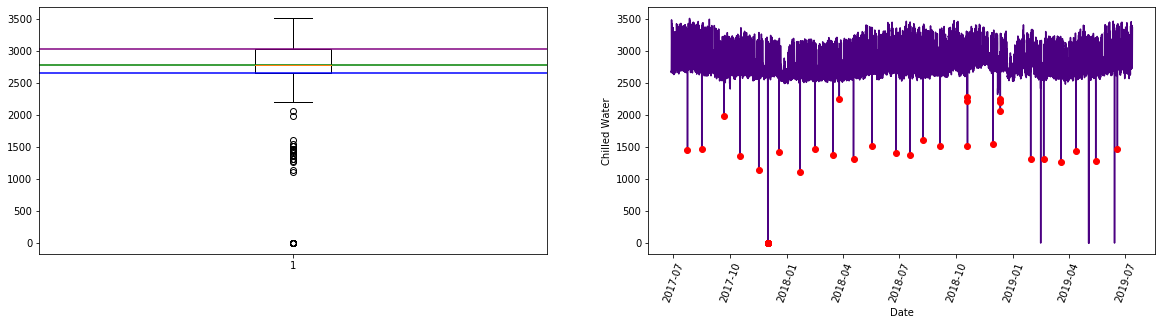

In [16]:
data = np.array(series)
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.boxplot(data)
twenty_fifth_percentile = np.percentile(data, 25)
seventy_fifth_percentile = np.percentile(data, 75)
median = np.percentile(data, 50)
points = [twenty_fifth_percentile, median, seventy_fifth_percentile]
text = ["Q1", "Median", "Q3"]
colors = ['blue', 'green', 'purple']
for p, c in zip(points, colors):
    plt.axhline(y = p, color=c)
iqr = seventy_fifth_percentile - twenty_fifth_percentile
threshold = twenty_fifth_percentile - 1*iqr
outliers = [v for v in series.values.tolist() if v < threshold]
plt.subplot(2, 2, 2)
plt.plot(series.index, series.values, color = 'indigo')
for outlier in outliers:
    index = series.values.tolist().index(outlier)
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = 'r', marker = 'o')
plt.xlabel("Date")
plt.ylabel("Chilled Water")
plt.xticks(rotation=70)



# 2D Aggo Clustering (Different Outlier Detection)



In [ ]:
#this also clusters using agglomerative with outside air temp and chilled water
#HOWEVER - rather than just extracting the topmost cluster, which ends up getting a similar result to 1d
#this function extracts points that are x SD outside of the cluster (outside air temperature)
#this extracts outliers that are associated with differing air temps even if not obvious outliers in the 1d series
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.lines import Line2D
import random
#use outside air temperature as x, since it correlates very well with chilled water + heating
new_df = pd.merge_asof(df, df2, on = "Timestamp")
new_df = new_df.dropna()
#x = temperature
x = new_df.iloc[:, 2]
#y = chilled water
y = new_df.iloc[:, 1]
#combined, new 2d data
data = new_df.iloc[:, [2, 1]]
agg_cluster = AgglomerativeClustering(n_clusters = 10)
#fit to data
agg_cluster.fit(data)
labels = agg_cluster.labels_
agg_df = pd.DataFrame(dict(x = x, y = y, labels = labels, Timestamp = new_df['Timestamp']))
#dummy column
agg_df['dummy'] = random.sample(range(1, 10000000), agg_df.shape[0])
fig = plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.scatter(x, y, c=labels, cmap='viridis') 
plt.xlabel("Outside Air Temp")
plt.ylabel("Chilled Water")
#extract outliers
plt.subplot(2, 2, 2)
unique_labels = np.unique(labels.tolist())
outliers = []
dummies = []



for label in unique_labels:
    #subset the df so that it only contains that cluster
    subsetted_df = agg_df.loc[agg_df['labels'] == label]
    #extract the threshold for that cluster
    #outside air temperature, just for that cluster
    t = subsetted_df['x'].tolist()
    upper_threshold = np.mean(t) + 2.5*np.std(t)
    lower_threshold = np.mean(t) - 2.5*np.std(t)
    m = list(range(subsetted_df.shape[0]))
    for i in m:
        point = subsetted_df['x'].tolist()[i]
        dummy_point  = subsetted_df['dummy'].tolist()[i]
        if point > upper_threshold or point < lower_threshold:
            outliers.append(point)
            #use a dummy column since every outlier point is not unique, therefore when indexing 
            #the outlier later in the original data, we can use the dummy value associated with the outlier point first
            #otherwise we may have an outlier, say 70, that appears several times in the original data
            #then when extracting the index, it could extract the wrong index because 70 is not unique
            dummies.append(dummy_point)

    
#plot outliers            
plt.scatter(x, y, c = labels)
for dummy in dummies:
    #extract the index associated with the dummy outlier
    index = agg_df['dummy'].tolist().index(dummy)
    #use that to extract the outside air temperature outlier
    temp_outlier = agg_df['x'].tolist()[index]
    chilled_outlier = agg_df['y'].tolist()[index]
    plt.plot(temp_outlier, chilled_outlier, color = 'red', marker = 'o')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers',
                         markersize=5)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("Outside Air Temperature")
plt.ylabel("Chilled Water")

#plot data with outliers
plt.subplot(2, 2, 3)
plt.plot(agg_df['Timestamp'].tolist(), agg_df['y'].tolist())
for dummy in dummies:
    outlier_index = agg_df['dummy'].tolist().index(dummy)
    chilled_outlier = agg_df['y'].tolist()[outlier_index]
    chilled_date = new_df['Timestamp'].tolist()[outlier_index]
    plt.plot(chilled_date, chilled_outlier, c = 'red', marker = 'o')
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Chilled Water")
plt.title("Data With Outliers")

#plot data with outliers removed, use dummy column
plt.subplot(2, 2, 4)
non_outlier_indexes = [i for i in list(range(agg_df.shape[0])) if agg_df['dummy'].tolist()[i] not in dummies]
non_outlier_data = [agg_df['y'].tolist()[i] for i in non_outlier_indexes]
non_outlier_dates = [agg_df['Timestamp'].tolist()[i] for i in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data, color = 'aquamarine' )
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Chilled Water")
plt.title("Data Without Outliers")








# Training+Testing

In [22]:
new_df = pd.merge_asof(df, df2, on = "Timestamp")
new_df = new_df.dropna()
new_df.index = new_df.iloc[:, 0]
new_df = new_df.drop(['Timestamp'], axis = 1)
r = new_df.iloc[:, 0].rolling(window=2).mean()
r = r.fillna(r.mean())
